In [1]:
import numpy as np 
from scipy.io import loadmat
import os
from os.path import join as opj
from h5py import File
import pandas as pd

# load CLIP from huggingface, load the first N images and extract the features
from transformers import CLIPProcessor, CLIPModel
import torch
import tqdm
from PIL import Image

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_path ="/home/matteo/storage/THINGS_Monkey"
monkey = "F"
os.listdir(base_path)

['THINGS_normMUA_F.mat',
 'THINGS_normMUA_N.mat',
 'THINGS_MUA_trials_N.mat',
 'THINGS_MUA_trials_F.mat',
 'THINGS_normMUA.mat',
 'things_imgs_F.mat']

In [3]:
import scipy.io as sio
import numpy as np

# Load normalized MUA data
norm_mua = sio.loadmat(opj(base_path,'THINGS_normMUA.mat'))
train_MUA = norm_mua['train_MUA']  # [#electrode x #stimuli]
test_MUA = norm_mua['test_MUA']    # [#electrode x #stimuli]


In [4]:
things_imgs = File(opj(base_path,f'things_imgs_{monkey}.mat'))
train_imgs = things_imgs['train_imgs']
test_imgs = things_imgs['test_imgs']

In [5]:
things_imgs["train_imgs"].keys()


<KeysViewHDF5 ['class', 'local_path', 'things_path']>

In [6]:
def resolve_reference(hdf5_file, ref):
    """
    Resolve an HDF5 dataset reference and convert it into a string.
    """
    data = hdf5_file[ref][:]
    return ''.join(chr(i) for i in data.flatten() if i > 0)


In [7]:
train_classes = []
train_local_paths = []
train_things_paths = []

test_classes = []
test_local_paths = []
test_things_paths = []

with File(opj(base_path, f"things_imgs_{monkey}.mat")) as f:
    train_imgs = f['train_imgs']
    
    train_classes = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['train_imgs']['class']]
    train_local_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['train_imgs']['local_path']]
    train_things_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['train_imgs']['things_path']]

    test_classes = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['test_imgs']['class']]
    test_local_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['test_imgs']['local_path']]
    test_things_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['test_imgs']['things_path']]





In [8]:
# Print the extracted information
print("First 5 classes:", train_classes[:5])
print("First 5 local paths:", train_local_paths[:5])
print("First 5 THINGS paths:", train_things_paths[:5])


print("First 5 classes:", test_classes[:5])
print("First 5 local paths:", test_local_paths[:5])
print("First 5 THINGS paths:", test_things_paths[:5])

print(len(train_things_paths)), print(len(test_things_paths))

First 5 classes: ['aardvark', 'aardvark', 'aardvark', 'aardvark', 'aardvark']
First 5 local paths: ['\\\\vs03\\VS03-VandC-3\\THINGS\\Passive_Fixation\\_stims\\THINGS_train\\00001.bmp', '\\\\vs03\\VS03-VandC-3\\THINGS\\Passive_Fixation\\_stims\\THINGS_train\\00002.bmp', '\\\\vs03\\VS03-VandC-3\\THINGS\\Passive_Fixation\\_stims\\THINGS_train\\00003.bmp', '\\\\vs03\\VS03-VandC-3\\THINGS\\Passive_Fixation\\_stims\\THINGS_train\\00004.bmp', '\\\\vs03\\VS03-VandC-3\\THINGS\\Passive_Fixation\\_stims\\THINGS_train\\00005.bmp']
First 5 THINGS paths: ['aardvark\\aardvark_01b.jpg', 'aardvark\\aardvark_02s.jpg', 'aardvark\\aardvark_03s.jpg', 'aardvark\\aardvark_04s.jpg', 'aardvark\\aardvark_05s.jpg']
First 5 classes: ['alligator', 'altar', 'ashtray', 'axe', 'bamboo']
First 5 local paths: ['\\\\vs03\\VS03-VandC-3\\THINGS\\Passive_Fixation\\_stims\\THINGS_test\\00001.bmp', '\\\\vs03\\VS03-VandC-3\\THINGS\\Passive_Fixation\\_stims\\THINGS_test\\00002.bmp', '\\\\vs03\\VS03-VandC-3\\THINGS\\Passive_Fix

(None, None)

In [9]:
trials = File(opj(base_path, f"THINGS_MUA_trials_{monkey}.mat"))


In [10]:
df =pd.DataFrame(trials["ALLMAT"][:].T, columns=["#trial_idx", "#train_idx", "#test_idx", "#rep", "#count", "#correct"])

df["#trial_idx"] = df["#trial_idx"].astype(int)
df["#train_idx"] = df["#train_idx"].astype(int)
df["#test_idx"] = df["#test_idx"].astype(int)
df["#rep"] = df["#rep"].astype(int)
df["#count"] = df["#count"].astype(int)

df

,#trial_idx,#train_idx,#test_idx,#rep,#count,#correct
0,1,16504,0,1,1,1.0
1,2,16470,0,1,2,1.0
2,3,15094,0,1,3,1.0
3,4,2514,0,1,4,1.0
4,5,4860,0,1,1,1.0
...,...,...,...,...,...,...
25243,25244,0,40,30,1,4.0
25244,25245,13906,0,1,2,4.0
25245,25246,470,0,1,3,4.0
25246,25247,15559,0,1,4,4.0


In [11]:
data = trials["ALLMUA"][:]

In [13]:
data.shape

(300, 25248, 1024)

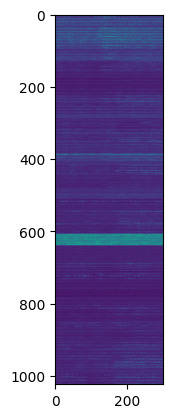

In [12]:
import matplotlib.pyplot as plt
plt.imshow(data[:,0,:].T)

## Map trials to images

In [15]:
# train_img_path = []

train_indices = df[df["#train_idx"]!=0]["#train_idx"].values - 1
test_indices = df[df["#test_idx"]!=0]["#test_idx"].values - 1

In [25]:
# train_indices.max(), train_things_paths[-1],train_things_paths[train_indices.max()]

In [26]:
sorted_train_img_path = [train_things_paths[i] for i in train_indices]
sorted_test_img_path = [test_things_paths[i] for i in test_indices]


In [28]:
# sorted_train_img_path

In [29]:
thing_base_path ="/home/matteo/storage/THINGS_img/"

In [189]:
 N = 15000


In [31]:



device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")



/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [32]:
def extract_features(model, images):

    images = [Image.open(img).convert("RGB") for img in images]
    inputs = processor(images= images, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    return outputs

In [54]:
# a = [opj(thing_base_path,"THINGS","Images", img).replace("\\","/") for img in sorted_train_img_path[i:i+batch]]
# images = [Image.open(img).convert("RGB") for img in a]

# inputs = processor(images=images, return_tensors="pt", padding=True)



In [190]:
batch = 256

train_features = []

# for i in tqdm.trange(0, len(sorted_train_img_path), batch):
for i in tqdm.trange(0, N, batch):
    features = extract_features(model, [opj(thing_base_path,"THINGS","Images", img).replace("\\","/") for img in sorted_train_img_path[i:i+batch]])
    train_features.append(features.cpu().numpy())

100%|██████████| 59/59 [04:52<00:00,  4.96s/it]


In [191]:
test_features = []

for i in tqdm.trange(0, len(sorted_test_img_path), batch):
    features = extract_features(model, [opj(thing_base_path,"THINGS","Images", img).replace("\\","/") for img in sorted_test_img_path[i:i+batch]])
    test_features.append(features.cpu().numpy())


100%|██████████| 12/12 [00:22<00:00,  1.89s/it]


In [192]:
train_features = np.concatenate(train_features, axis=0)[:N]
test_features = np.concatenate(test_features, axis=0)

In [194]:
# train_features.shape, val_features.shape

In [ ]:
neural_train_trial_idx = df[df["#train_idx"]!=0]["#trial_idx"].values - 1
neural_test_trial_idx = df[df["#test_idx"]!=0]["#trial_idx"].values - 1

In [ ]:
# neural_train_trial_idx

In [196]:
train_neural = data[100:,neural_train_trial_idx[:N]].mean(0)
test_neural = data[100:,neural_test_trial_idx].mean(0)
print(train_neural.shape, test_neural.shape)




(15000, 1024) (3000, 1024)


In [197]:
## average the test activity over the repetitions (test_indices equals)

test_indices = df[df["#test_idx"]!=0]["#test_idx"].values - 1

#for all the indices with the same test_idx, average the neural activity
test_neural_avg = []
test_features_avg = []
selected_test_imgs = []
for idx in np.unique(test_indices):
    test_neural_avg.append(test_neural[test_indices==idx].mean(0))

    #same for the test features
    test_features_avg.append(test_features[test_indices==idx].mean(0))
    selected_test_imgs.append(np.array(sorted_test_img_path)[test_indices==idx][0])

test_neural_avg = np.array(test_neural_avg)
test_features_avg = np.array(test_features_avg)
selected_test_imgs = np.array(selected_test_imgs)



In [ ]:
# selected_test_imgs

In [198]:
test_neural_avg.shape, test_features_avg.shape, train_features.shape, train_neural.shape


((100, 1024), (100, 512), (15000, 512), (15000, 1024))

## Encoding model

In [199]:
from himalaya.ridge import RidgeCV
from sklearn.preprocessing import StandardScaler

std = StandardScaler()


ridge = RidgeCV(alphas=[0.1,1,10,100,1e3,1e4]).fit(train_features, train_neural)


In [200]:
from scipy.stats import pearsonr

channels = []

test_neural_pred = ridge.predict(test_features_avg)
for i in range(test_neural_avg.shape[1]):
    channels.append(pearsonr(test_neural_avg[:,i], test_neural_pred[:,i])[0])

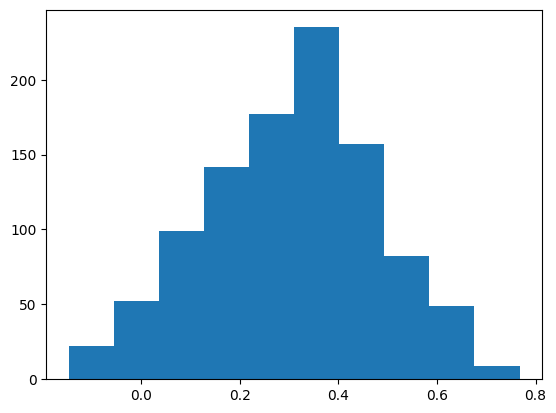

DescribeResult(nobs=1024, minmax=(-0.14667012551645553, 0.7675678398653678), mean=0.3043133827770711, variance=0.029941735150549625, skewness=-0.12052494983069917, kurtosis=-0.31972851632017507)

In [201]:
## measure correlation
from scipy.stats import describe

plt.hist(channels)
plt.show()

describe(channels)

## Decoding model

In [202]:
std = StandardScaler()
std.fit(train_neural)
train_neural_std = std.transform(train_neural)
test_neural_std = std.transform(test_neural_avg)


In [203]:
decoding_model = RidgeCV(alphas=[10,100,500,1e3,3e3,1e4]).fit(train_neural_std,train_features)

test_features_pred = decoding_model.predict(test_neural_std)

In [204]:
test_features_pred.mean(), test_features_avg.mean(), test_features_pred.std(), test_features_avg.std()

(0.000715736277176523, -0.00978082, 0.08758857749679778, 0.47710544)

In [205]:
selected_train_imgs = sorted_train_img_path[:N]



In [206]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors


# Number of nearest neighbors to find
n_neighbors = 5

# Create and fit the NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=n_neighbors)
nn_model.fit(test_features_avg)

# Find the nearest neighbors for the adjusted embeddings
distances, nearest_neighbors_indices = nn_model.kneighbors(test_features_pred)

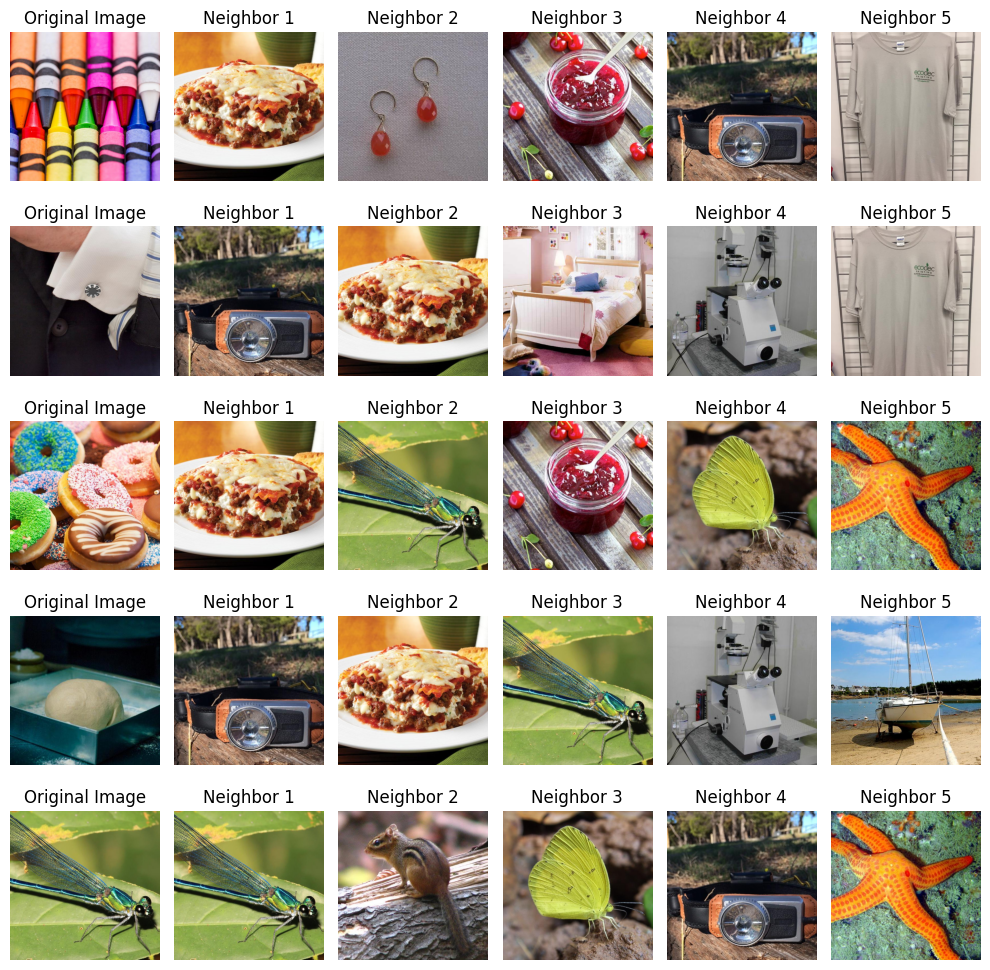

In [207]:
idx = 30

fig, axs = plt.subplots(5, n_neighbors+1, figsize=(10, 10))

for j in range(5):
    axs[j, 0].imshow(Image.open(opj(thing_base_path,"THINGS","Images", selected_test_imgs[idx+j]).replace("\\","/")))
    axs[j, 0].axis("off")
    axs[j, 0].set_title("Original Image")

    for i, neighbor_idx in enumerate(nearest_neighbors_indices[idx+j]):
        img = Image.open(opj(thing_base_path,"THINGS","Images", selected_test_imgs[neighbor_idx]).replace("\\","/"))
        axs[j, i+1].imshow(img)
        axs[j, i+1].axis("off")
        axs[j, i+1].set_title(f"Neighbor {i+1}")

plt.tight_layout()
# # Plot the original image
# img = Image.open(opj(thing_base_path,"THINGS","Images", selected_test_imgs[idx]).replace("\\","/"))
# axs[0].imshow(img)
# axs[0].axis("off")
# axs[0].set_title("Original Image")

# # Plot the nearest neighbors
# for i, neighbor_idx in enumerate(nearest_neighbors_indices[idx]):
#     img = Image.open(opj(thing_base_path,"THINGS","Images", selected_test_imgs[neighbor_idx]).replace("\\","/"))
#     axs[i+1].imshow(img)
#     axs[i+1].axis("off")

In [208]:
## measure accuracy

correct = 0
correct_top5 = 0
for i in range(len(nearest_neighbors_indices)):

    if i==nearest_neighbors_indices[i][0]:
        correct += 1

    if i in nearest_neighbors_indices[i]:
        correct_top5 += 1

top1 = correct/len(nearest_neighbors_indices)
top5 = correct_top5/len(nearest_neighbors_indices)

top1, top5



(0.06, 0.22)

## Provare con normMUA